In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
from utils import ECDF
from data import load_kruschke

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Bayesian comparison of two (or more) groups

Comparison of two groups is a ubiquitous inference task. You'll find it in many places:

- Experimental biologists have a control group and some treatment.
- Marketers call this A/B testing.
- In clinical research, we'll have a case and control group, in which the case group receives an intervention. 

In this notebook, we will be introducing the use of PyMC3, a probabilistic programming language for Bayesian statistical modelling, and we will show how you can use PyMC3 to perform inference on this common statistical task.

This notebook will be more guided than the latter ones, to help you get familiar with the syntax.

## Problem 1: The Intervention-IQ Problem

### Data Credits

The data for this exercise was obtained from John Kruschke's paper, [Bayesian Estimation supersedes the T-test][best]. The data come from a fictional study of a drug and its effect on IQ, and have been slightly modified for pedagogical reasons.

[best]: http://www.indiana.edu/~kruschke/BEST/BEST.pdf

### Setup

You are consulting for an academic research group, which would like to independently evaluate whether an intervention boosts IQ or not. To investigate this problem, the research group has set up a case-control study, comparing the IQ of students with and without the intervention. 

### Step 1: Define Data Generating Process

Without looking at the data, let us first think about the generative model for the data. 

Generative models, you might ask?

A generative model is not necessarily a mechanistic model, in which every last detail is captured. Rather, a generative model lets us use probability distributions to express how the data were generated.

One strategy for the data generating process is to go forward from first principles. This tends to be more mechanistic and principled, particularly when we are modelling a physical system or a known process.

The other strategy is to go backwards from what the data might look like. This is useful when we do not have all of the necessary details, and is a flexible way to approximate how our data were generated. 

For this particular problem, we will take the latter strategy. 

#### Intervention IQ Data Generating Process

The data generating process for this problem may be specified as such:

1. We know that the IQ can be approximately modelled by normal distributions. 
    1. Because interventions in humans are generally expensive, we typically take few samples. Thus, instead of a normal distribution, which makes strong assumptions about having skinny tails (low probability mass in the extremes), we might want its more flexible cousin, the t-distribution. 
    1. This forms the **likelihood function** for the data.
1. The t-distribution is parameterized by three parameters:
    1. Mean
    1. Variance (or standard deviation)
    1. Degrees of Freedom (DoF)
1. It is for these data parameters for which we require **priors**. 
    1. Mean: Assuming no good prior information, it is common to use a relatively wide normal distribution: $\mu \sim N(0, 100)$
    1. Variance: Should be positive. Assuming no prior information, use a relatively flat positive distribution: $\sigma \sim HalfCauchy(100)$
    1. Degrees of Freedom ($\nu$): Should be positive and not equal to zero. We know some properties of DoF: when degrees of freedom is equal to 1, the t-distribution is equivalent to a Cauchy distribution, and as degrees of freedom go to infinity, the t-distribution becomes more and more like a Normal distribution.
        1. This is a nuisance parameter - we need it for modelling with the t-distribution, but we don't really care about it .
        1. [Questions have been asked][stats_exchange] regarding what are good priors. Check out [this link][stats_exchange] for more information.
        1. Therefore, just as with the other parameters, we can assign a fairly flat degree of freedom parameter, and let the data speak for itself.
        
        
[stats_exchange]: https://stats.stackexchange.com/questions/6492/whats-a-good-prior-distribution-for-degrees-of-freedom-in-a-t-distribution

With this setup, we have *explicitly stated our assumptions* about what we believe about the data generating process, prior to having seen any data.

In pictures, that big chunk of bullet points above can be visualized as follows:

![](../images/kruschke_model.jpg)

### Step 2: Explore the Data

Now that we have a first-pass generative model for the data, let's do some quick sanity checks against the data.

Let's get started by loading the data!

In [2]:
df = load_kruschke()
df.sample(5)

,treatment,iq,treatment_enc
77,placebo,102.0,1
24,drug,97.0,0
2,drug,107.0,0
25,drug,106.0,0
75,placebo,101.0,1


**Exercise:** Plot the number of samples for drug and for treatment.

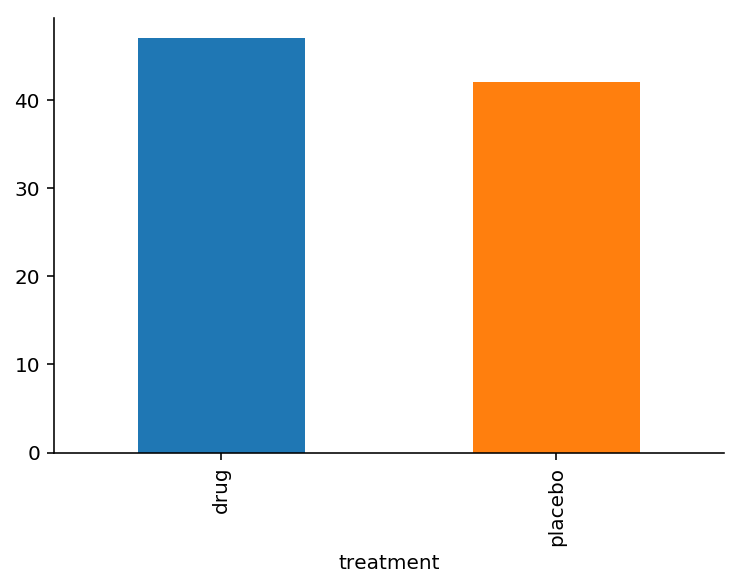

In [3]:
df.groupby('treatment').size().plot(kind='bar')  # blank out "treatment"

More important than the number of samples per treatment is the distribution of IQ, which will give us a hint as to whether we can expect a difference in effect.

**Exercise:** Plot the ECDF of the treatments vs. control. If you need to inspect the source code of ECDF, it is available below.

In [4]:
ECDF??

Signature: ECDF(data)
Source:   
def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y
File:      ~/github/tutorials/bayesian-stats-modelling-tutorial/notebooks/utils.py
Type:      function


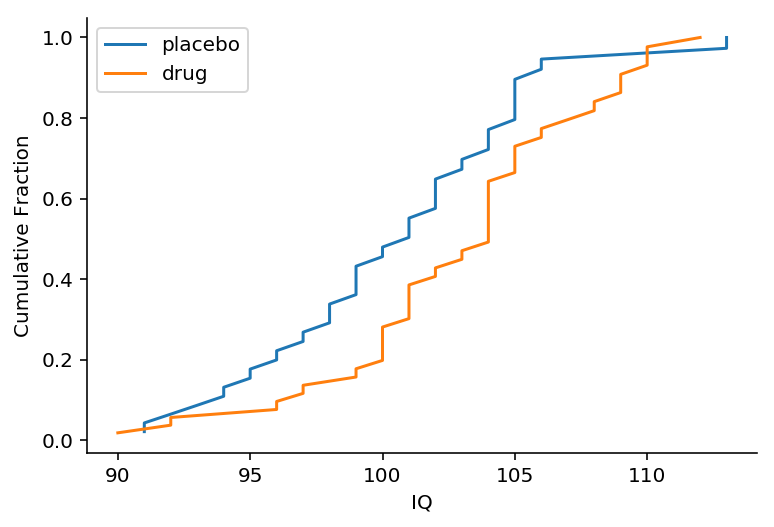

In [5]:
placebo_filter = df['treatment'] == 'placebo'
drug_filter = df['treatment'] == 'drug'

fig, ax = plt.subplots(nrows=1, ncols=1)
x_ctrl, y_ctrl = ECDF(df[placebo_filter]['iq'])
x_treat, y_treat = ECDF(df[drug_filter]['iq'])

ax.plot(x_ctrl, y_ctrl, label='placebo')
ax.plot(x_treat, y_treat, label='drug')
ax.set_xlabel('IQ')
ax.set_ylabel('Cumulative Fraction')
ax.legend()

**Discuss:** Does it look like the treatment had an effect on the IQ of the participants? What numbers from the chart above can help support your conclusions?

### Step 3: Fit Model

**Exercise:** We will specify the model below. Fill in the distributions as we go along in class. We are proceeding slowly here, simply to give you repetition practice with PyMC3's syntax.

In [6]:
with pm.Model() as kruschke_model:
    
    # Prior for drug-treated IQ mean.
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    # Prior for placebo-treated IQ mean.
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    
    # Prior for drug treated IQ standard deviation.
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    # Prior for placebo treated IQ standard deviation.
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    
    # Prior for nuisance parameter. Adding a small positive number 
    # guarantees that we never get nu == 0 by accident 
    # (e.g. through rounding error).
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    # Likelihood function for the drug-treated participants' IQ.
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=df[drug_filter]['iq'])
    
    # Likelihood function for the placebo-treated participants' IQ.
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=df[placebo_filter]['iq'])
    
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sigma_drug, 2) + 
                                         np.power(sigma_placebo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

A few pointers to help you read the code.

PyMC3 distributions are implemented using Distribution objects. Their object names match their distribution names. This is a very nice implementation detail of PyMC3! Additionally, [the docs][pymc3] show the parameters that are accepted; occasionally, the default parameterization might differ from what you have seen before, so referring to the docs is very important. 

[pymc3]: http://docs.pymc.io

`pm.Deterministic` allows us to compute a deterministic transform on the random variables. Wrapping this in a Deterministic object allows us to hook the result of the transformation into the tools used later for visualizing posterior distributions.

Now, we hit the Inference Button!

In [7]:
# Fill in `kruschke_model`
with kruschke_model:
    # Fill in `pm.sample(2000)`
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sigma_placebo_log__, sigma_drug_log__, mu_placebo, mu_drug]
100%|██████████| 2500/2500 [00:06<00:00, 389.90it/s]


Let's visualize the posterior distribution.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c23c6aeb8>,
      dtype=object)

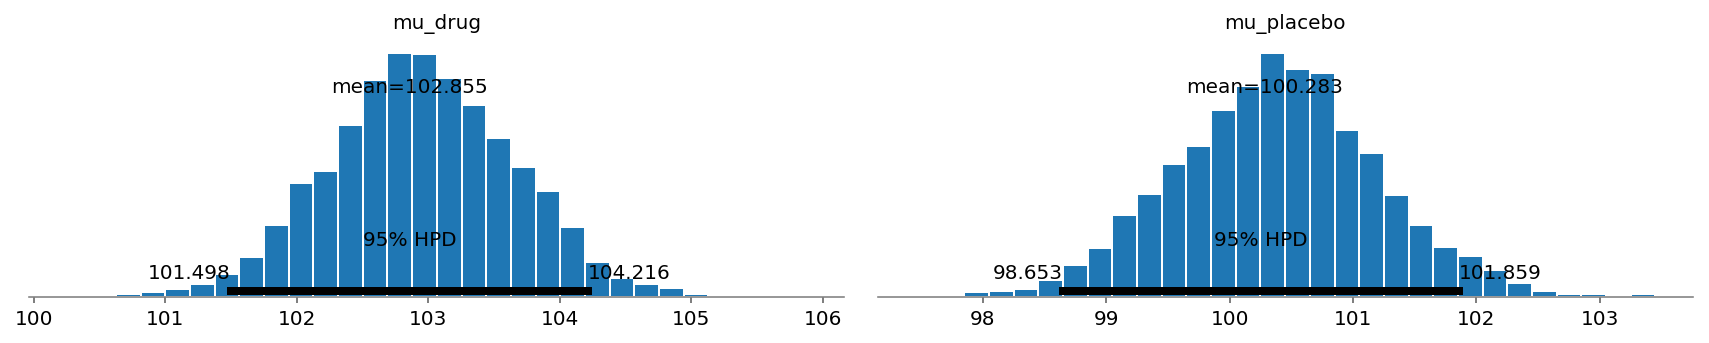

In [8]:
# Use `pm.plot_posterior()`
pm.plot_posterior(trace, varnames=['mu_drug', 'mu_placebo'])

### Step 4: Evaluate Model

We use posterior predictive checks (PPC) as one tool in our toolkit to evaluate and critique the model. The overarching goal of the PPC is to check that the data generating model generates simulated data that matches closely to the actual data. If this is the case, then we have a model that probably describes the data generating process well. If this is not the case, then we have evidence to go guide us towards re-doing the model.

**Exercise:** To do a PPC, PyMC3 provides a `sample_ppc` function, which allows us to draw samples from the posterior distribution as a check. Run the following cell, filling in the appropriate `trace` and `model`.

In [9]:
samples = pm.sample_ppc(trace=trace, samples=500, model=kruschke_model)

100%|██████████| 500/500 [00:00<00:00, 965.07it/s]


**Exercise:** Let's now plot the ECDF of the sampled data against the original data.

In [10]:
samples['drug'].shape

(500,)

Text(0.5,0,'IQ')

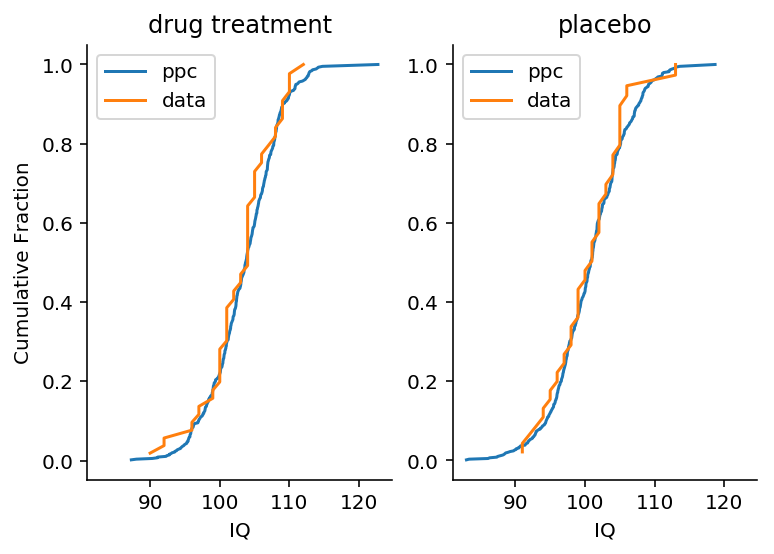

In [11]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex=True)

x, y = ECDF(samples['drug'])  # Want ECDF of drug-treatment PPC samples
ax1.plot(x, y, label='ppc')
x, y = ECDF(df[drug_filter]['iq'])  # Want ECDF of drug-treatment data
ax1.plot(x, y, label='data')
ax1.legend()
ax1.set_title('drug treatment')
ax1.set_xlabel('IQ')
ax1.set_ylabel('Cumulative Fraction')

x, y = ECDF(samples['placebo'])  # Want ECDF of placebo-treatment PPC samples
ax2.plot(x, y, label='ppc')
x, y = ECDF(df[placebo_filter]['iq'])  # Want ECDF of placebo-treatment data
ax2.plot(x, y, label='data')
ax2.legend()
ax2.set_title('placebo')
ax2.set_xlabel('IQ')

It looks like we have a model that, just by eyeballing the charts, models pretty well the distribution of the observed data.

For pedagogical brevity, we did not dive into a case where the model was plausibly but nonetheless incorrectly specified. Under an incorrect model, we would expect the PPC and data distributions to be anywhere from moderately to wildly off. Having detected this from a visual comparison of the PPC samples and data, we would go back and try to see where we went wrong. We might also opt to quantify this difference using the tools provided in PyMC3. 

**Exercise:** Now, let us evaluate whether the drug actually did have an effect. Recall that we computed the difference in means, as well as an effect size, both with uncertainty. Using this information, plot the posterior distribution of the difference in means and effect sizes.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c240f3eb8>,
      dtype=object)

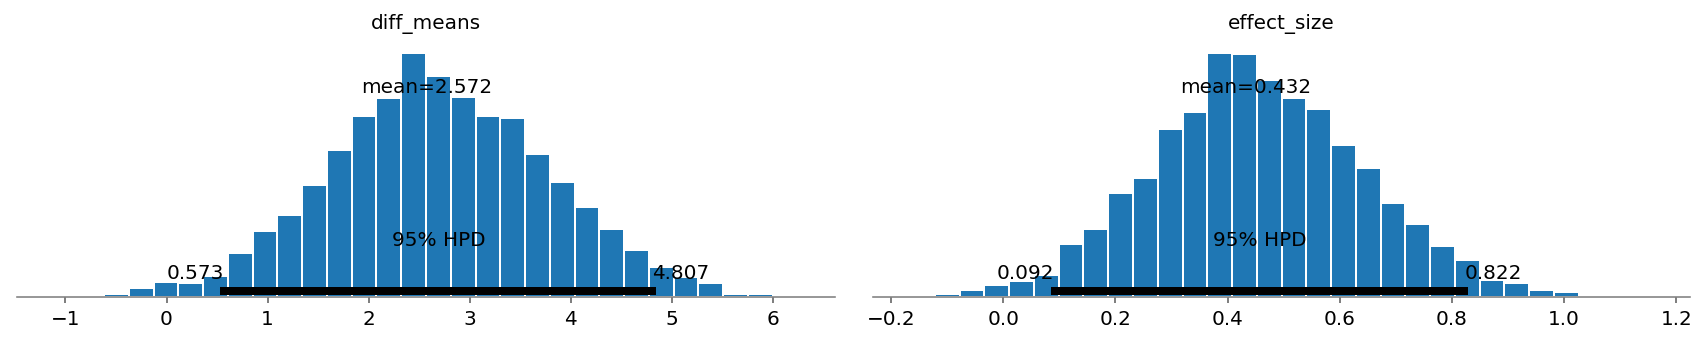

In [12]:
pm.plot_posterior(trace=trace, varnames=['diff_means', 'effect_size'])

Questions:

1. What is the 95% highest posterior density (HPD) interval for the difference of means?
1. What is the 95% HPD interval for the effect size?

**Excercise:** Compute the p-value of the t-test for this dataset.

In [13]:
from scipy.stats import ttest_ind

ttest_ind(df[placebo_filter]['iq'], df[drug_filter]['iq'], equal_var=False)

Ttest_indResult(statistic=-2.2756936448780114, pvalue=0.025378475627288653)

**Discuss**:
1. Is there a significant difference between the drug-treated and placebo-treated participants of the intervention? (This question is intentionally vague on the definition of "significant", to encourage discussion of the difference between statistical and practical significance.)
1. Would you recommend the intervention as a method to raise people's IQ? How much money would you be willing to pay for this intervention?

## Further Reading/Watching

- PyMC3's documentation contains an example of how to do [model selection][model_selection], which we did not touch on here. 
- John Kruschke's paper on [Bayesian Estimation][bayes_est] is what this notebook's example is based on. There is also a [YouTube video][bayes_yt] available.

[model_selection]: https://docs.pymc.io/notebooks/GLM-model-selection.html
[bayes_est]: http://www.indiana.edu/~kruschke/BEST/BEST.pdf
[bayes_yt]: https://www.youtube.com/watch?v=fhw1j1Ru2i0

## Alternative Syntax

There is an alternative syntax that can be used, one that takes advantage of numpy-like fancy indexing. See it below:

In [14]:
with pm.Model() as kruschke_model_alt:
    
    # We have two mus, therefor we have a vector of distributions of shape (2,).
    # Likewise for sds.
    mus = pm.Normal('mu', mu=0, sd=100**2, shape=(2,))
    sds = pm.HalfCauchy('sigma', beta=100, shape=(2,))
    
    # Prior for nuisance parameter. Adding a small positive number 
    # guarantees that we never get nu == 0 by accident 
    # (e.g. through rounding error).
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    # Likelihood function for the IQ values.
    # Fancy indexing allows us 
    likelihood = pm.StudentT('likelihood', nu=nu, mu=mus[df['treatment_enc']], 
                             sd=sds[df['treatment_enc']], observed=df['iq'])
    
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', mus[0] - mus[1])
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sds[0], 2) + 
                                         np.power(sds[1], 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

In [15]:
with kruschke_model_alt:
    trace_alt = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sigma_log__, mu]
100%|██████████| 2500/2500 [00:07<00:00, 313.84it/s]


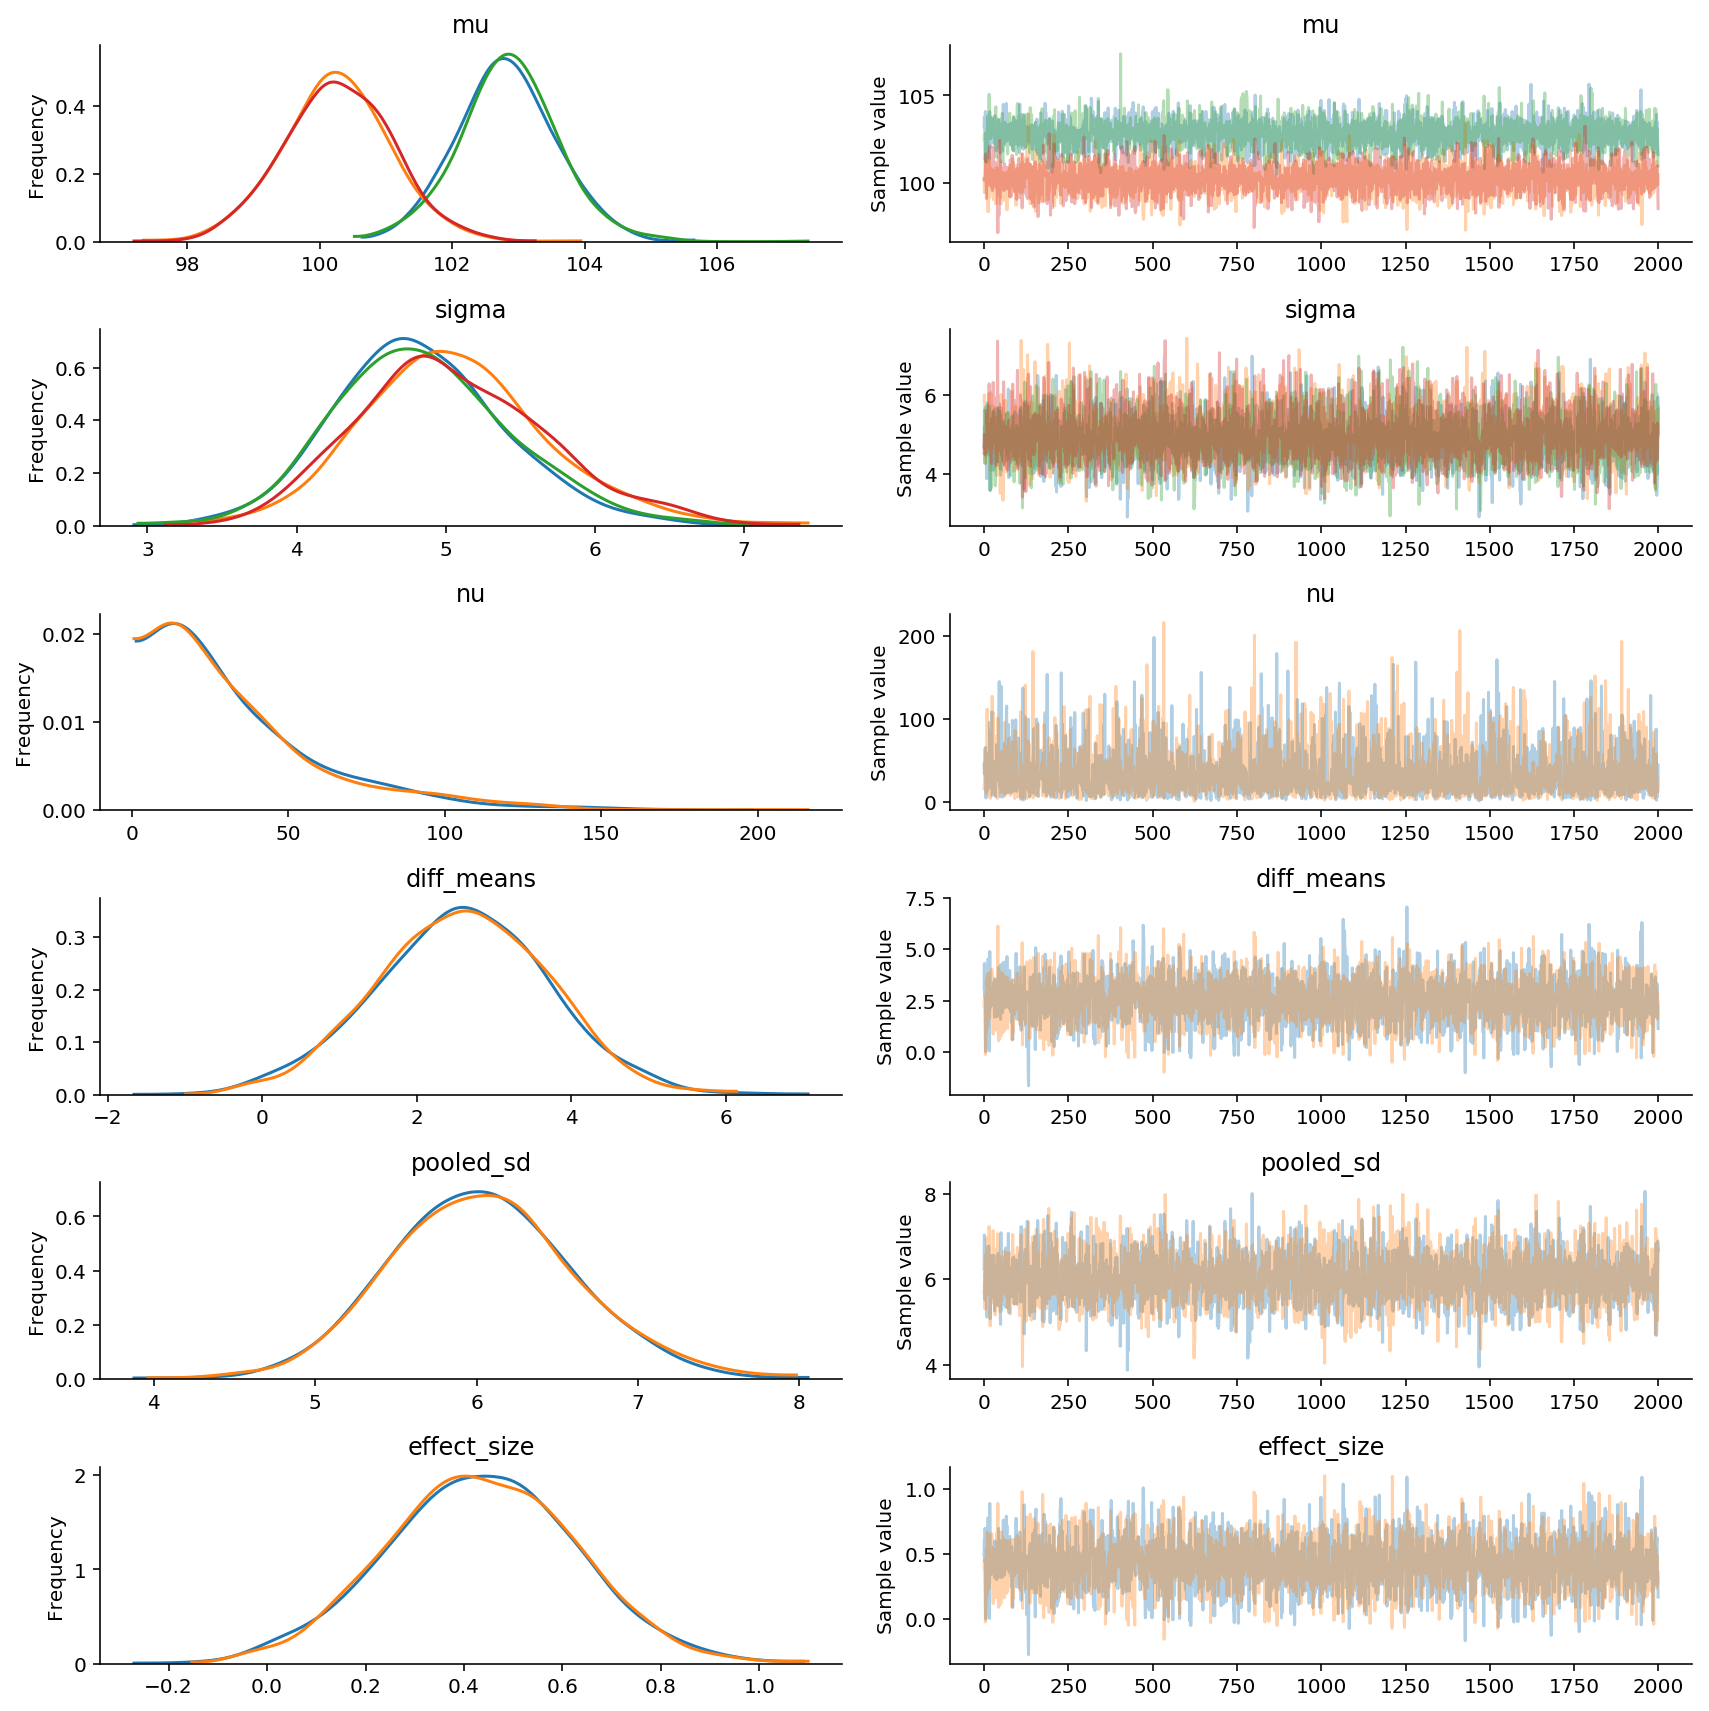

In [16]:
traces = pm.traceplot(trace_alt)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c241724e0>,
      dtype=object)

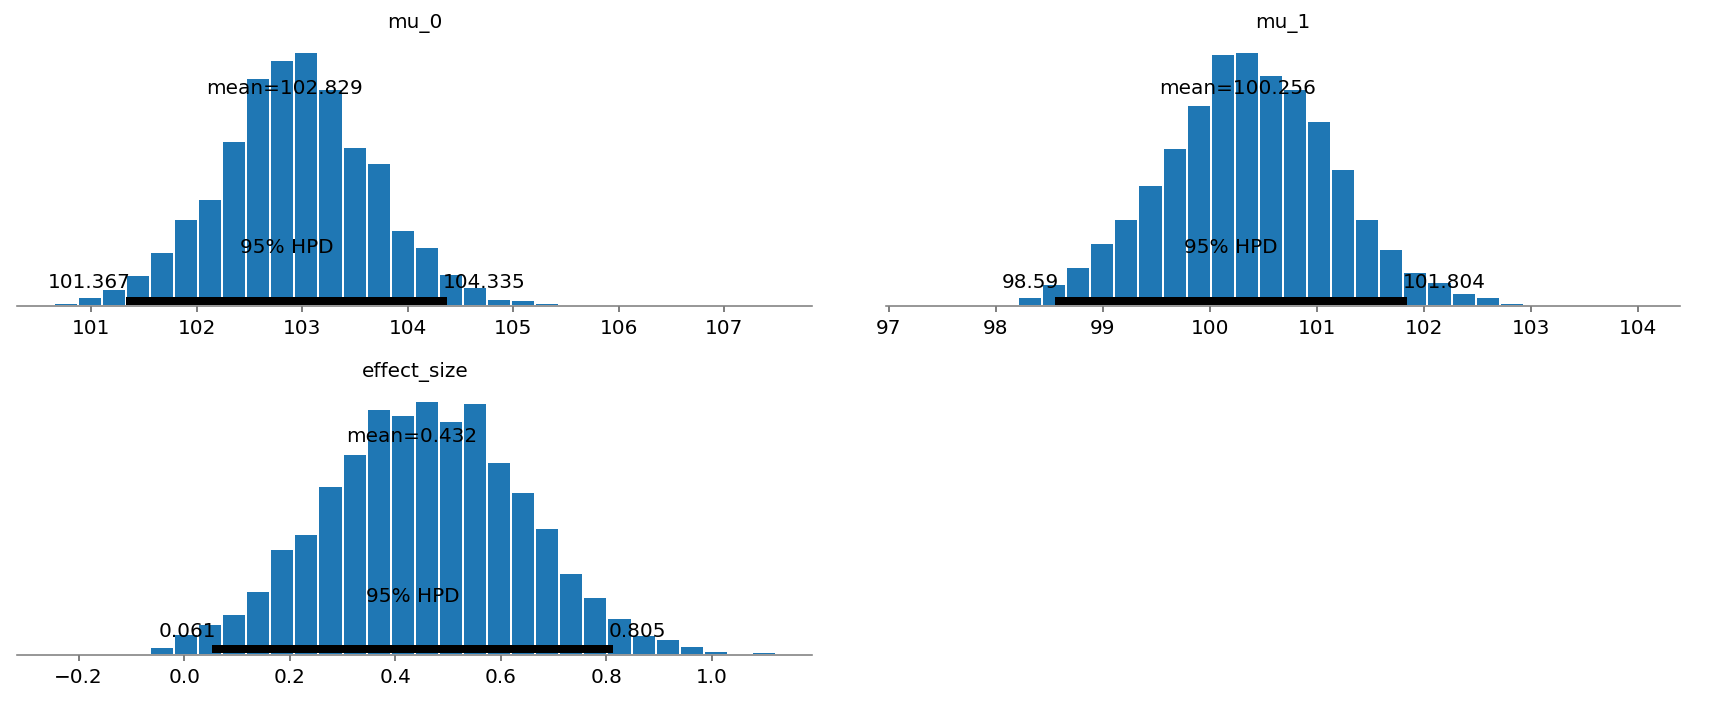

In [17]:
pm.plot_posterior(trace_alt, varnames=['mu', 'effect_size'])

# Next Steps

If you are feeling comfortable with PyMC3's syntax, in particular fancy indexing, and would like to move onto trying your hand at solving an inference problem without more guidance, then please proceed to Notebook 5.

If you are feeling the need to get more practice with PyMC3's syntax, then proceed to Notebook 4.